## Import

In [1]:
from common_imports import *

c:\Users\user\anaconda3\envs\2024_stock_project\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Stock Index Futures Data Preprocessing

In [2]:
# 디렉토리 설정
directory = './data/Futures_KOSPI/'

# 모든 데이터를 저장할 빈 DataFrame 생성
stock_data = pd.DataFrame()

# 디렉토리 내의 모든 파일을 순회
for filename in tqdm(sorted(os.listdir(directory))):
    if filename.endswith('.xlsx'):
        # 각 파일의 경로 생성
        file_path = os.path.join(directory, filename)
        
        # 파일 내의 모든 시트를 읽어서 하나의 DataFrame으로 결합
        df = pd.concat(pd.read_excel(file_path, sheet_name=None), ignore_index=True)
        
        # 결합된 데이터를 stock_data에 추가
        stock_data = pd.concat([stock_data, df], ignore_index=True)

# 결과 DataFrame 확인
print(stock_data.head())

100%|██████████| 35/35 [00:14<00:00,  2.34it/s]

                 time    open    high     low   close  volume
0 2022-02-10 09:00:00  370.70  371.90  370.70  371.55    7202
1 2022-02-10 09:01:00  371.55  371.85  371.35  371.80    3007
2 2022-02-10 09:02:00  371.80  372.10  371.45  371.65    3332
3 2022-02-10 09:03:00  371.65  371.80  371.50  371.65    1575
4 2022-02-10 09:04:00  371.65  371.70  371.30  371.45    1585


In [3]:
# 'time' 열을 datetime 형태로 변환
stock_data['time'] = pd.to_datetime(stock_data['time'])

# 날짜별로 행의 수 계산
daily_counts = stock_data.groupby(stock_data['time'].dt.date).size()

print(daily_counts)

time
2022-02-10    396
2022-02-11    396
2022-02-14    396
2022-02-15    396
2022-02-16    396
             ... 
2024-12-23    411
2024-12-24    411
2024-12-26    411
2024-12-27    411
2024-12-30    411
Length: 708, dtype: int64


In [4]:
unique_values = daily_counts.unique()
print("Unique values:", unique_values)

Unique values: [396 380 336 411 395 351 382]


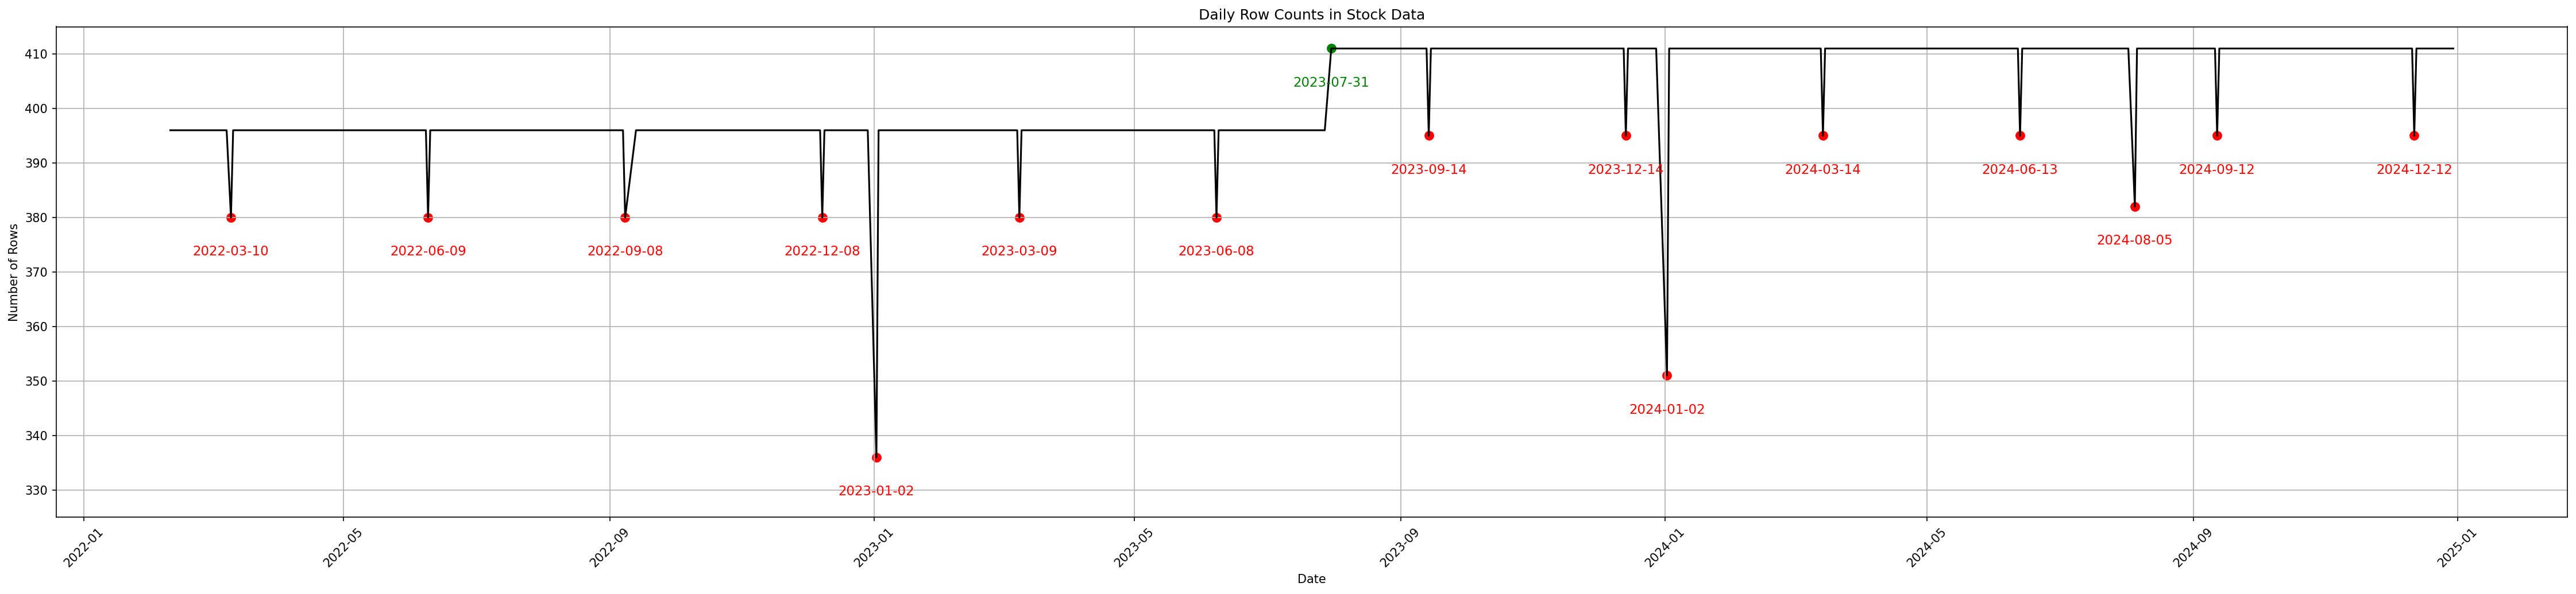

In [5]:
# daily_counts 데이터 시각화
plt.figure(figsize=(30, 7))
plt.plot(daily_counts.index, daily_counts.values, linestyle='-', color = 'black')

# 특정 행의 개수가 나타난 날짜를 강조
highlight_counts = [380, 336, 395, 351, 382]
for count in highlight_counts:
    highlight_dates = daily_counts[daily_counts == count].index
    for date in highlight_dates:
        plt.scatter(date, count, color='red', s=50)  # 각 날짜에 빨간색 점으로 표시
        plt.text(date, count - 7, f'{date.strftime("%Y-%m-%d")}', color='red', ha='center', fontsize=11)

# 396개에서 411개로 변경된 첫 날짜 찾기
first_change_date = daily_counts[(daily_counts.shift(1) == 396) & (daily_counts == 411)].index[0]
plt.scatter(first_change_date, 411, color='green', s=50)  # 변경점을 초록색 점으로 표시
plt.text(first_change_date, 411 - 7, f'{first_change_date.strftime("%Y-%m-%d")}', color='green', ha='center', fontsize=11)

# 그래프 설정
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.title('Daily Row Counts in Stock Data')
plt.grid(True)
plt.xticks(rotation=45)  # 날짜 레이블을 45도 회전
plt.ylim(325, 415)  # Y축의 범위 설정
plt.tight_layout()  # 레이아웃 조정

plt.show()

In [108]:
df = pd.read_csv("./Backtesting/summary/results_summary.csv")

In [109]:
# 첫 번째 컬럼(data_frame_name)을 '_' 기준으로 분리하여 숫자, 라벨, 유사도 종류 추출
def extract_tokens(name):
    parts = name.split('_')
    # parts[0]: 숫자, parts[1]: 라벨(숫자), parts[2]는 'future' 고정, 나머지는 유사도 종류
    number = parts[0]
    label = parts[1]
    similarity = '_'.join(parts[3:])  # 유사도 종류: 3번째 인덱스부터 끝까지 결합
    return pd.Series([number, label, similarity])

# 새로운 컬럼 생성
df[['number', 'label', 'similarity']] = df['data_frame_name'].apply(extract_tokens)

In [ ]:
# 숫자와 라벨 컬럼을 numeric type으로 변환 (라벨이 숫자값임)
df['number'] = pd.to_numeric(df['number'], errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# 숫자와 라벨 기준으로 전체 데이터프레임 정렬
df.sort_values(by=['number', 'label'], inplace=True)

# 저장 기본 경로
base_dir = "./Backtesting/summary"

# 1. 숫자와 라벨이 동일한 경우 그룹핑 및 저장
group1_folder = os.path.join(base_dir, "by_similarity_type")
os.makedirs(group1_folder, exist_ok=True)

for (number, label), group in df.groupby(['number', 'label']):
    # 파일 이름에 숫자형을 그대로 사용하기 위해 정수형으로 변환
    file_name = f"{int(number)}_{int(label)}.csv"
    group.to_csv(os.path.join(group1_folder, file_name), index=False)

# 2. 숫자와 유사도 종류가 동일한 경우 그룹핑 및 저장
group2_folder = os.path.join(base_dir, "by_window_size")
os.makedirs(group2_folder, exist_ok=True)

for (number, similarity), group in df.groupby(['number', 'similarity']):
    file_name = f"{int(number)}_{similarity}.csv"
    group.to_csv(os.path.join(group2_folder, file_name), index=False)

# 3. 라벨과 유사도 종류가 동일한 경우 그룹핑 및 저장
group3_folder = os.path.join(base_dir, "by_top_n")
os.makedirs(group3_folder, exist_ok=True)

for (label, similarity), group in df.groupby(['label', 'similarity']):
    file_name = f"{int(label)}_{similarity}.csv"
    group.to_csv(os.path.join(group3_folder, file_name), index=False)

## 그룹 별 분석

In [ ]:
for group in ['number', 'label', 'similarity']:
    grouped_df = df.iloc[:,1:24]
    grouped_df[group] = df[group]
    grouped_df = grouped_df.groupby([group]).mean().round(3)
    
    grouped_df.to_csv(f"./Backtesting/summary/by_{group}.csv")

#### 1. similarity

In [99]:
grouped_df = df.iloc[:,1:24]
grouped_df['similarity'] = df['similarity']
grouped_df = grouped_df.groupby(['similarity']).mean().round(3)

C:\Users\user\AppData\Local\Temp\ipykernel_4076\103286176.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df_viz.index, rotation=45, ha='right')


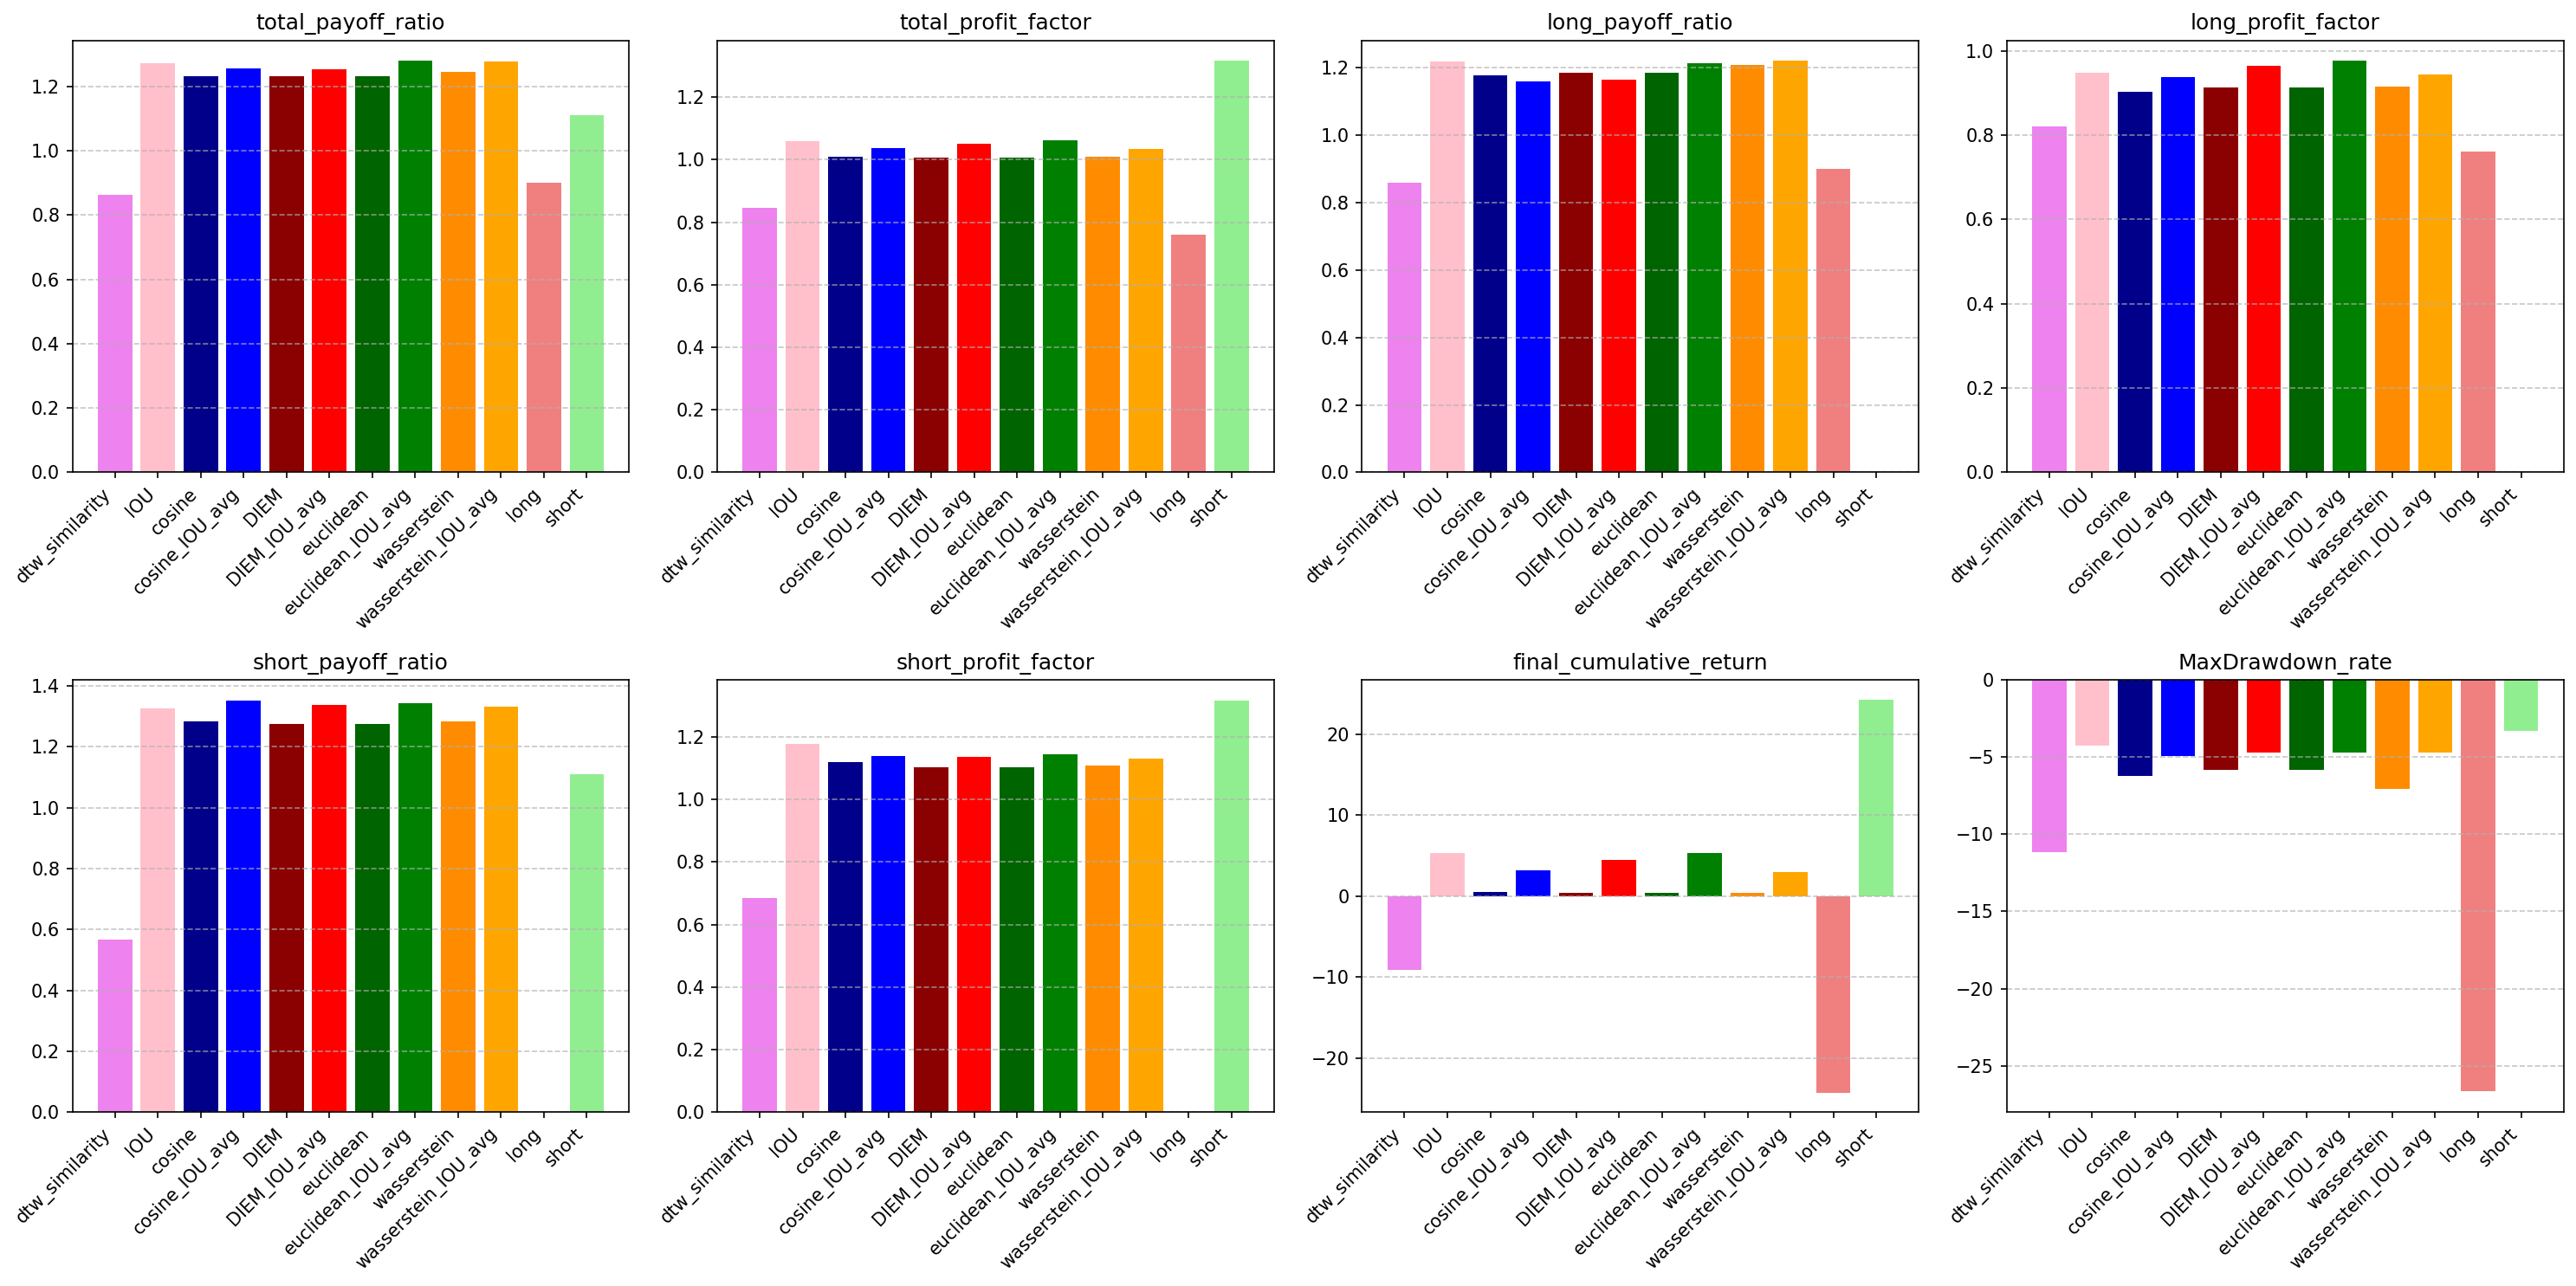

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# (1) 시각화할 지표 목록
metrics = [
    'total_payoff_ratio', 'total_profit_factor',
    'long_payoff_ratio', 'long_profit_factor',
    'short_payoff_ratio', 'short_profit_factor',
    'final_cumulative_return', 'MaxDrawdown_rate'
]

# (2) 색상 설정
benchmark_colors = {
    'long': 'lightcoral',  # 연한 빨강
    'short': 'lightgreen'    # 연한 초록
}

similarity_colors = {
    'dtw_similarity': 'violet',      
    'IOU': 'pink',                 
    'cosine': 'darkblue',                  
    'cosine_IOU_avg': 'blue',           
    'DIEM': 'darkred',               
    'DIEM_IOU_avg': 'red',           
    'euclidean': 'darkgreen',        
    'euclidean_IOU_avg': 'green',       
    'wasserstein': 'darkorange',            
    'wasserstein_IOU_avg': 'orange'
}

# (3) 전략 순서 재정의: 벤치마크는 좌측과 우측에 배치
# 'long'은 좌측(long), 'short'은 우측(short)로 사용
strategies_order = list(similarity_colors.keys()) + ['long'] + ['short']

# (4) 각 전략별 색상 매핑 (벤치마크는 별도 지정)
color_mapping = {
    strat: benchmark_colors['long'] if strat == 'long'
    else benchmark_colors['short'] if strat == 'short'
    else similarity_colors.get(strat, 'gray')
    for strat in strategies_order
}

# (5) grouped_df의 인덱스를 위의 순서대로 재정렬 (전략 이름이 인덱스로 되어 있다고 가정)
df_viz = grouped_df.loc[strategies_order]

# (6) 각 지표에 대해 서브플롯 생성 (2행 4열)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    # 각 전략에 대해 막대그래프 그리기, 각 막대는 지정된 색상 사용
    bars = ax.bar(df_viz.index, df_viz[metric], color=[color_mapping[strat] for strat in df_viz.index])
    ax.set_title(metric)
    ax.set_xticklabels(df_viz.index, rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
from math import pi

# 색상 정의
colors = {
    'long': 'lightcoral', 'short': 'lightgreen', 'dtw_similarity': 'violet', 'IOU': 'pink', 
    'cosine': 'darkblue', 'cosine_IOU_avg': 'blue', 'DIEM': 'darkred', 'DIEM_IOU_avg': 'red', 
    'euclidean': 'darkgreen', 'euclidean_IOU_avg': 'green', 'wasserstein': 'darkorange', 
    'wasserstein_IOU_avg': 'orange'
}

# 선택한 컬럼
categories = ['total_payoff_ratio', 'total_profit_factor', 
              'long_payoff_ratio', 'long_profit_factor', 
              'short_payoff_ratio', 'short_profit_factor',
              'final_cumulative_profit', 'max_realized_profit', 'MaxDrawdown_rate']
n = len(categories)

# categories가 비어 있는지 확인
if n == 0:
    raise ValueError("No categories selected for visualization. Please define 'categories'.")

# 데이터 정규화 함수
def normalize(series):
    min_val, max_val = series.min(), series.max()
    return (series - min_val) / (max_val - min_val) if max_val != min_val else series * 0 + 0.5

# 정규화된 데이터 준비
values = {cat: normalize(grouped_df[cat]) for cat in categories}
strategies = grouped_df.index

# 방사형 차트 준비
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, polar=True)

# 각도 계산
angles = [i / float(n) * 2 * pi for i in range(n)]
angles += angles[:1]

# 축 설정
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)

# 각 전략 그리기
for i, strategy in enumerate(strategies):
    strategy_values = [values[cat][i] for cat in categories]
    strategy_values += strategy_values[:1]  # 처음 값으로 닫기
    linewidth = 3 if strategy in ['long', 'short'] else 1.5
    ax.plot(angles, strategy_values, linewidth=linewidth, linestyle='solid', label=strategy, color=colors[strategy])
    ax.fill(angles, strategy_values, color=colors[strategy], alpha=0.25)

# 레전드 추가
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=10)
plt.title("Radar Chart of Trading Strategies", size=16, pad=20)
plt.show()

#### 2. Labeling Window size

In [42]:
grouped_df = df.iloc[:,1:24]
grouped_df['label'] = df['label']
grouped_df = grouped_df.groupby(['label']).mean().round(3)

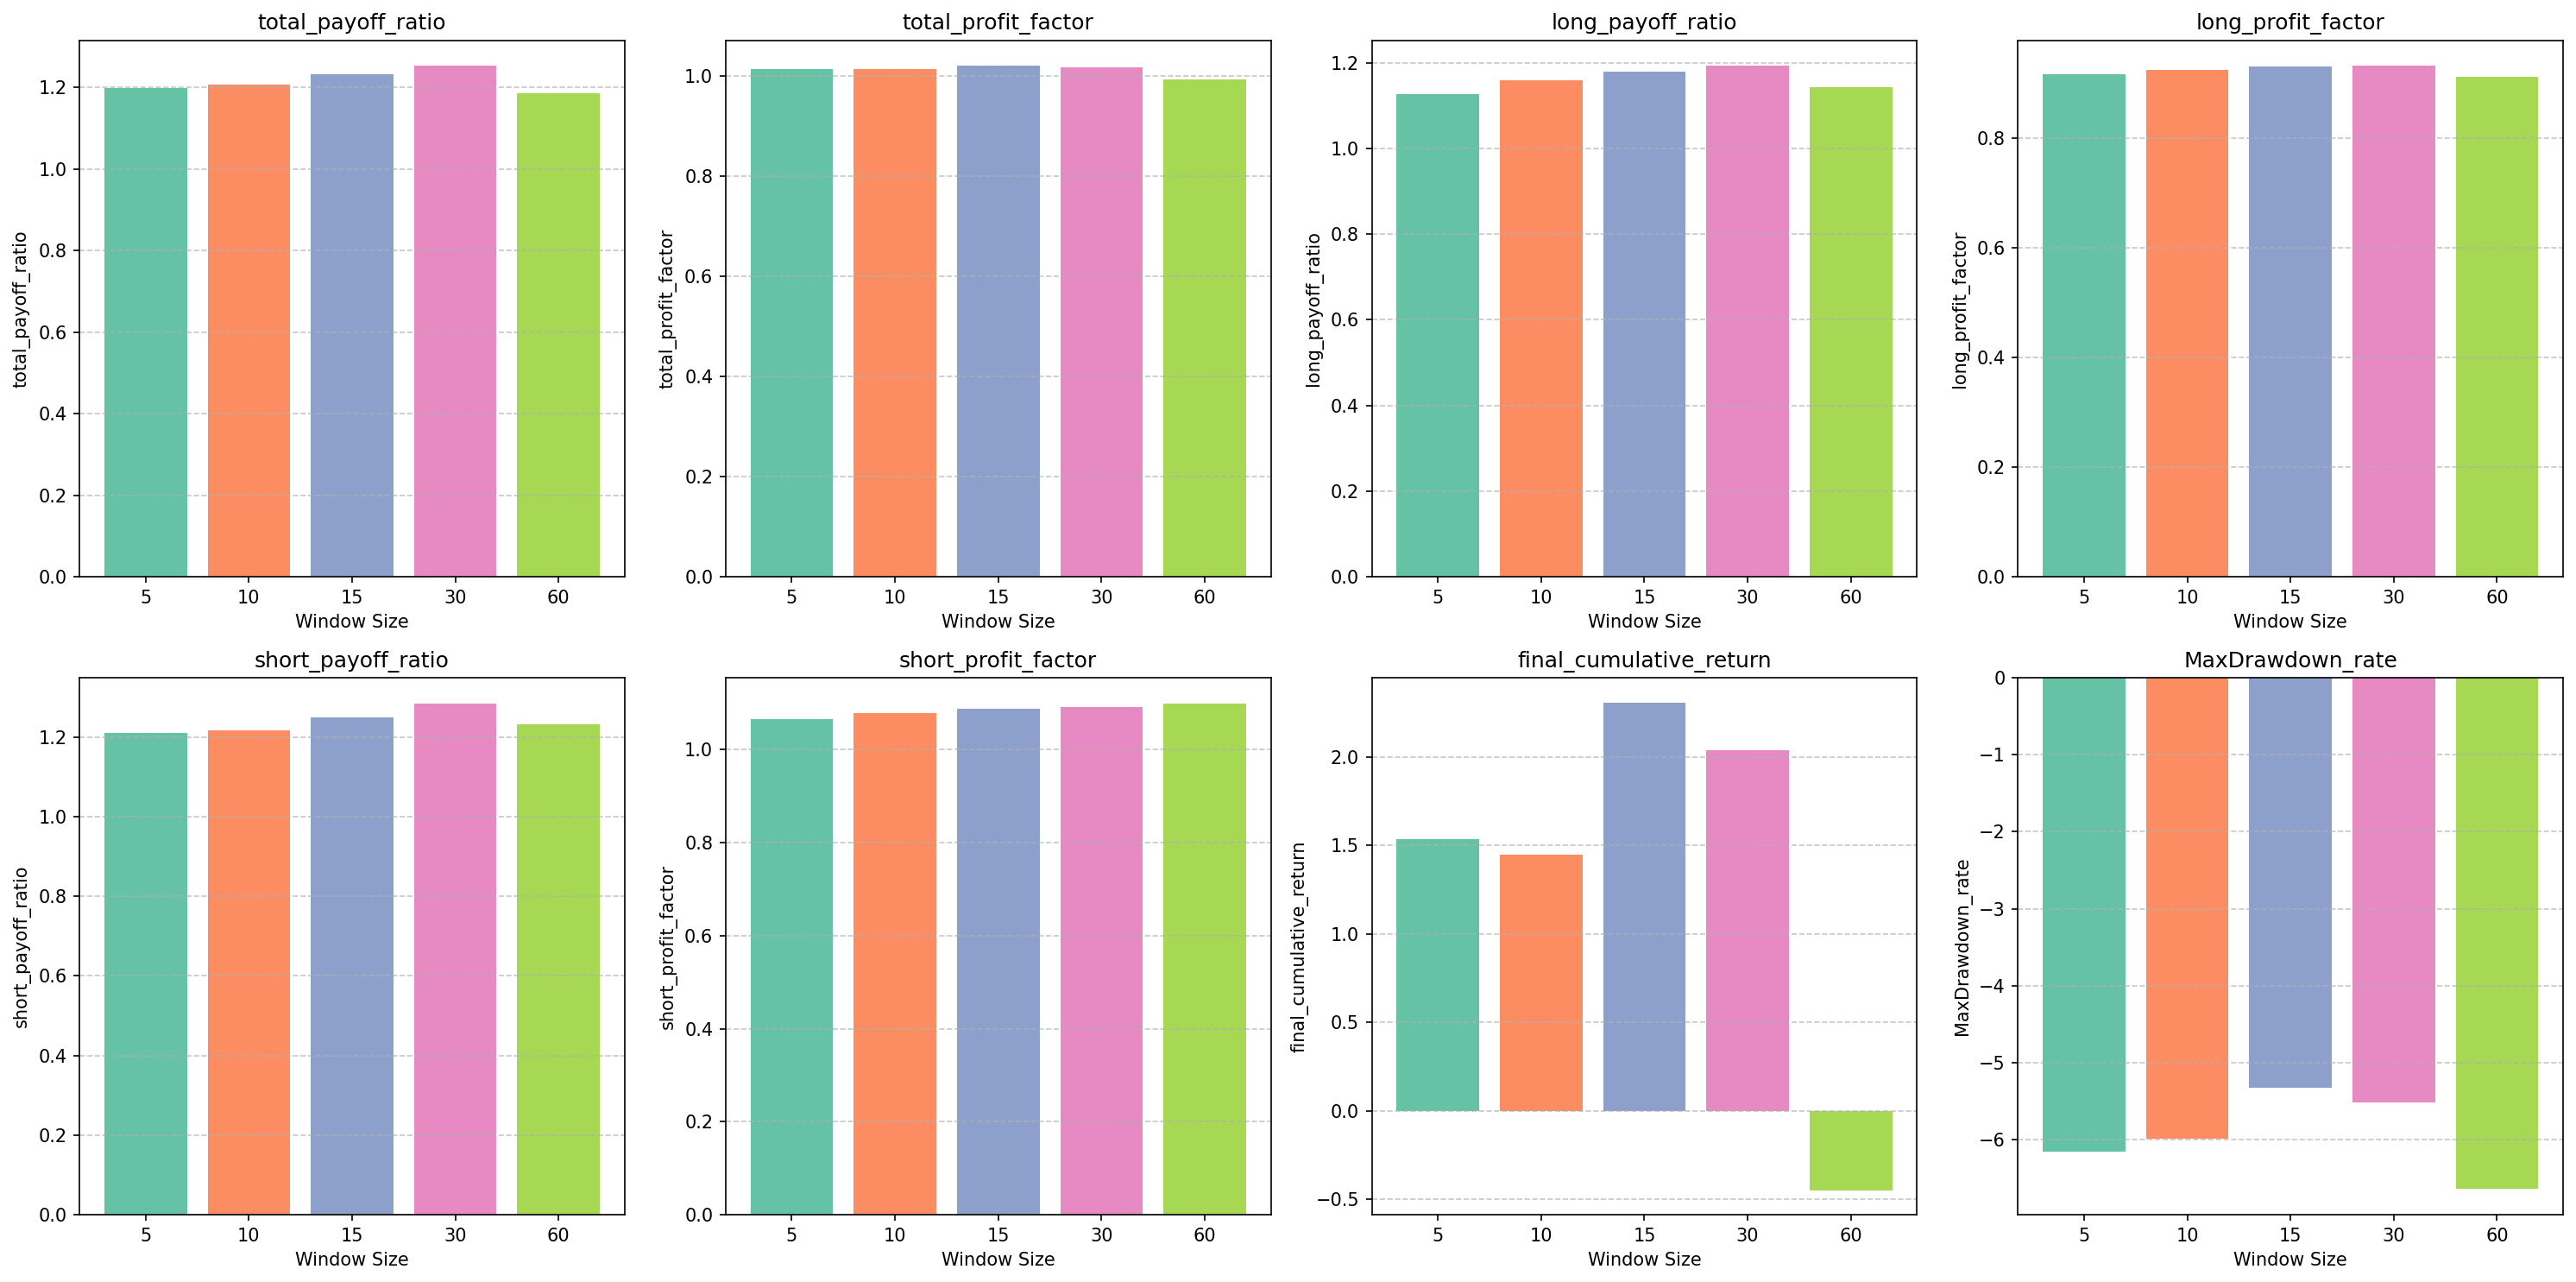

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# (1) 시각화할 지표 목록
metrics = [
    'total_payoff_ratio', 'total_profit_factor',
    'long_payoff_ratio', 'long_profit_factor',
    'short_payoff_ratio', 'short_profit_factor',
    'final_cumulative_return', 'MaxDrawdown_rate'
]

# (2) 색상 팔레트 및 창 크기별 색상 매핑 생성
window_size_palette = sns.color_palette("Set2", 5)  # 5가지 색상 팔레트
window_sizes = [5, 10, 15, 30, 60]
window_size_color_map = dict(zip(window_sizes, window_size_palette))

# (3) grouped_df를 사용한 시각화를 위해 인덱스(라벨)를 int형으로 변환
df_viz = grouped_df.copy()
df_viz.index = df_viz.index.astype(float).map(int)  # 인덱스가 5.0, 10.0 ...이면 5, 10, ...으로 변환

# (4) 각 지표에 대해 2행 4열 서브플롯 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    # 각 창 크기에 해당하는 색상 지정
    colors = [window_size_color_map[int(lbl)] for lbl in df_viz.index]
    
    ax.bar(df_viz.index.astype(str), df_viz[metric], color=colors)
    ax.set_title(metric)
    ax.set_xlabel("Window Size")
    ax.set_ylabel(metric)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
plt.tight_layout()
plt.show()


#### 3. Top N

In [45]:
grouped_df = df.iloc[:,1:24]
grouped_df['number'] = df['number']
grouped_df = grouped_df.groupby(['number']).mean().round(3)

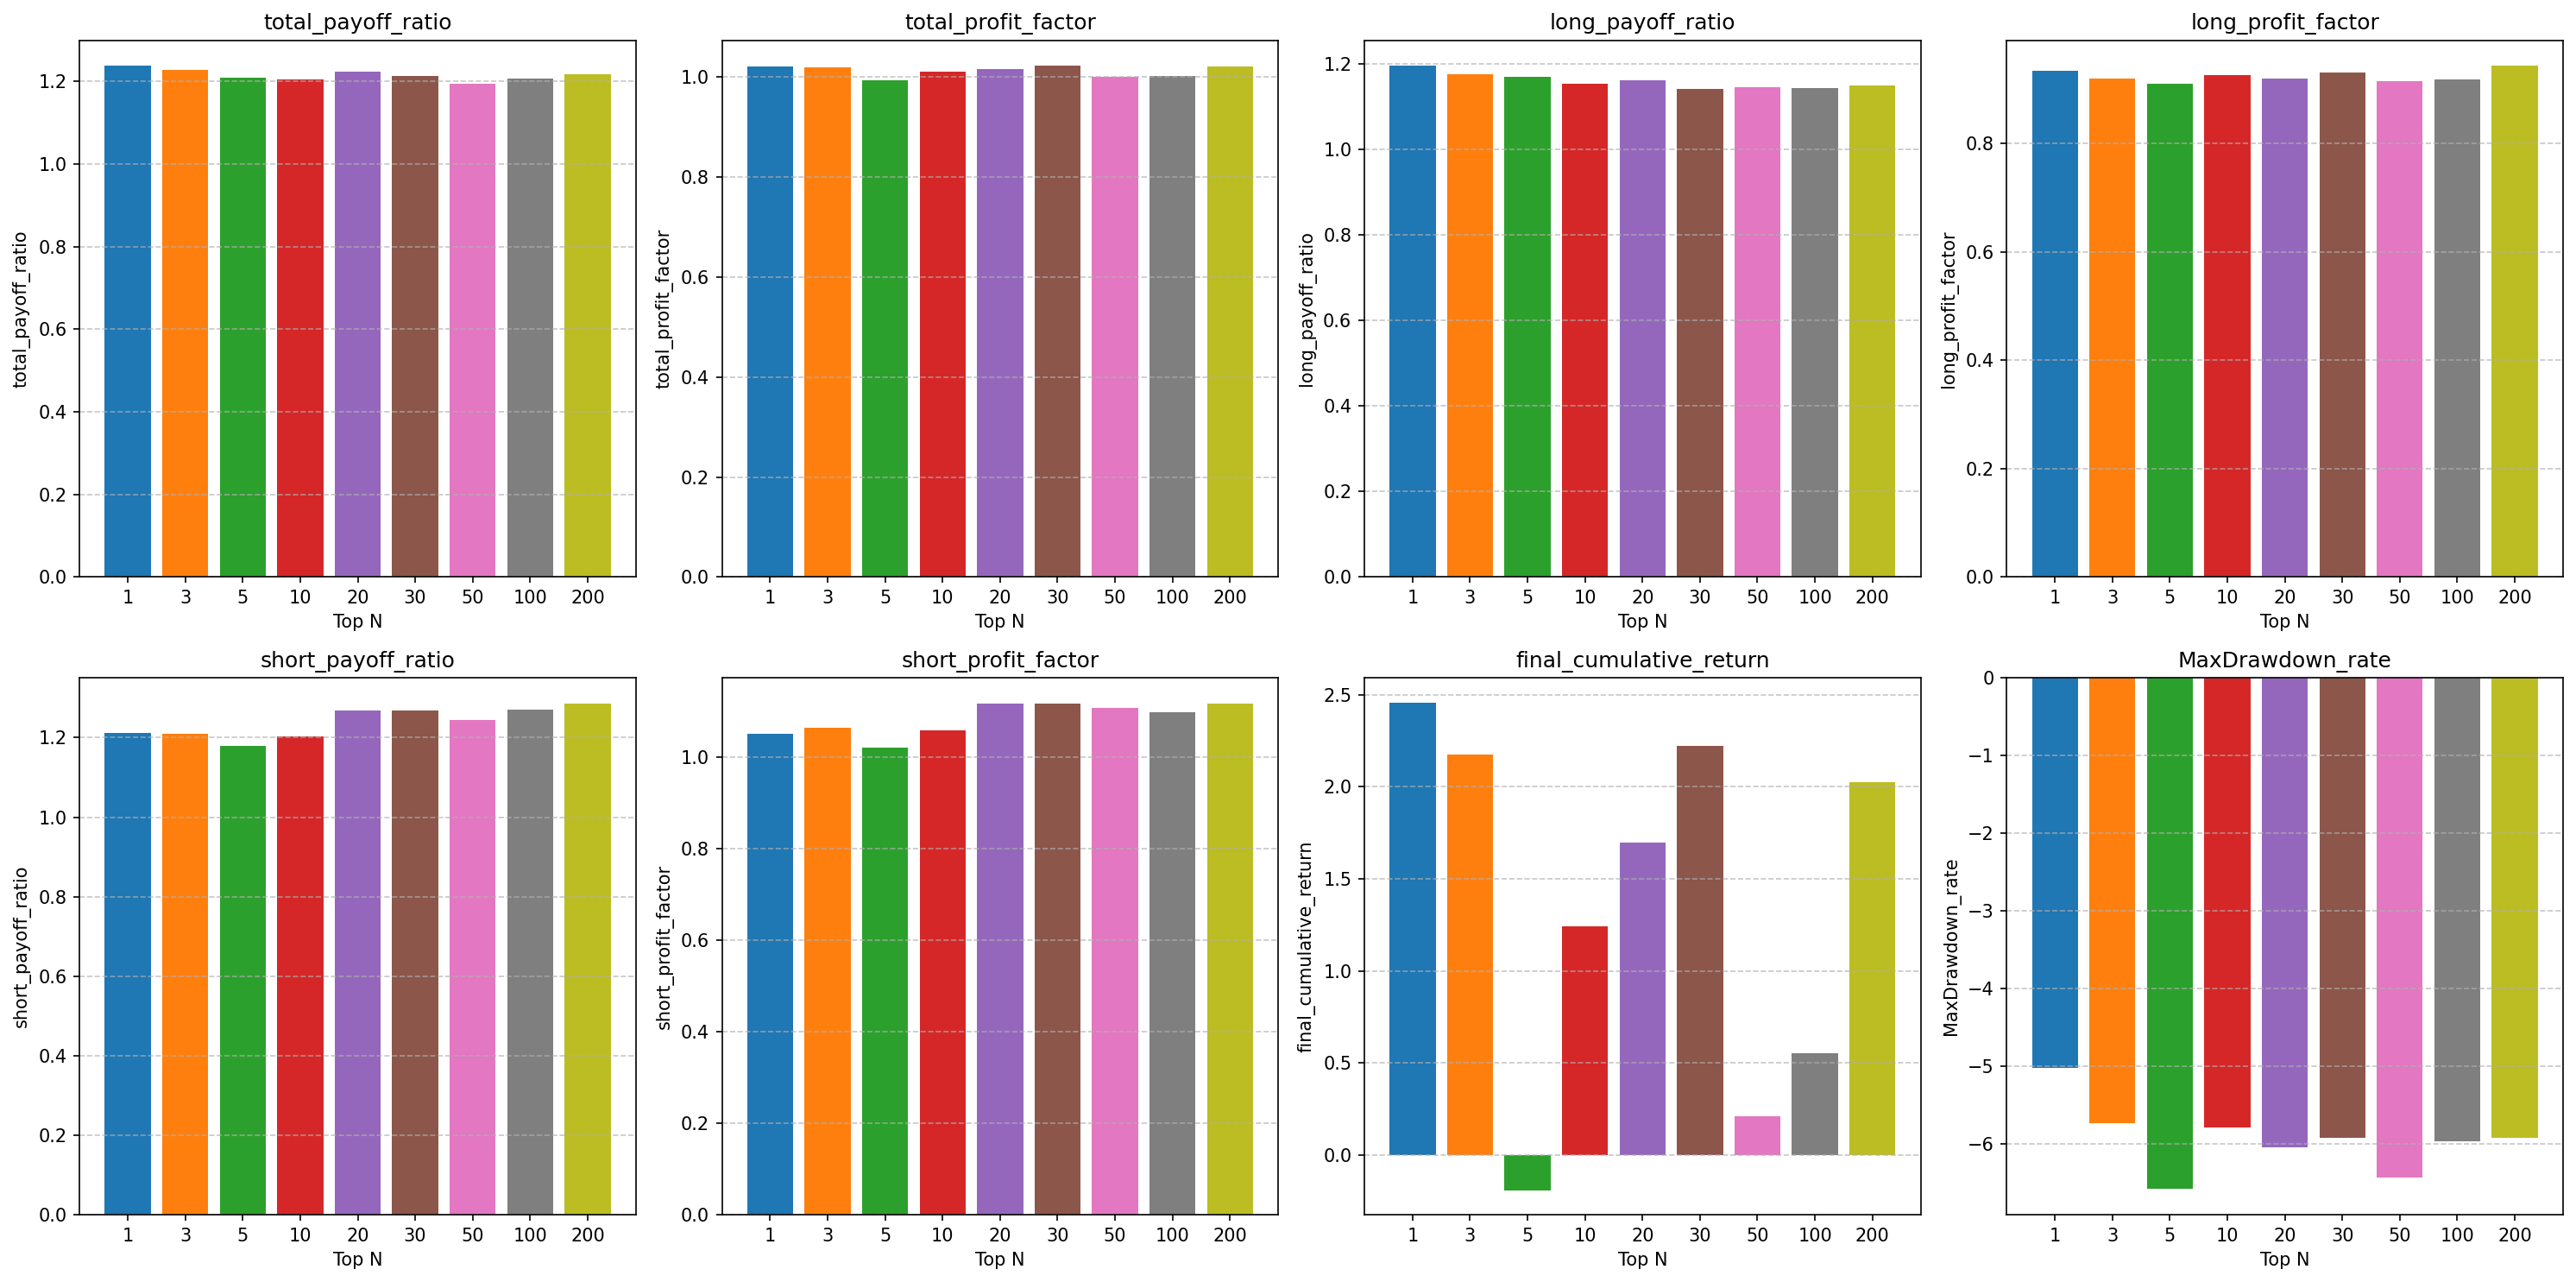

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# (1) 시각화할 성과 지표 리스트
metrics = [
    'total_payoff_ratio', 'total_profit_factor',
    'long_payoff_ratio', 'long_profit_factor',
    'short_payoff_ratio', 'short_profit_factor',
    'final_cumulative_return', 'MaxDrawdown_rate'
]

# (2) 색상 팔레트 및 Top N 값별 색상 매핑 생성
top_n_palette = sns.color_palette("tab10", 9)  # 9가지 색상 팔레트
top_n_values = [1, 3, 5, 10, 20, 30, 50, 100, 200]
top_n_color_map = dict(zip(top_n_values, top_n_palette))

# (3) grouped_df는 'number'를 인덱스로 가지므로, 인덱스를 정수형으로 변환
df_viz = grouped_df.copy()
df_viz.index = df_viz.index.astype(int)

# (4) 각 지표에 대해 2행 4열의 서브플롯 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    # 각 Top N 값에 해당하는 색상 지정
    colors = [top_n_color_map[val] for val in df_viz.index]
    
    ax.bar([str(val) for val in df_viz.index], df_viz[metric], color=colors)
    ax.set_title(metric)
    ax.set_xlabel("Top N")
    ax.set_ylabel(metric)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## GIF results

In [4]:
import imageio
import os
import re

# 이미지가 있는 상위 디렉토리 경로
base_dir = './Backtesting/plots/cumulative_profit/by_similarity_type'
gif_dir = './Backtesting/plots/cumulative_profit/GIF'

# GIF 폴더가 없으면 생성
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# 모든 하위 폴더를 검색
subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# 폴더 이름에서 숫자1, 숫자2를 추출하여 정렬하기
sorted_subdirectories = sorted(subdirectories, key=lambda x: (int(re.search(r'top_(\d+)_window_(\d+)', x).group(1)), int(re.search(r'top_(\d+)_window_(\d+)', x).group(2))))

all_images = []

# 각 폴더에 대해서 GIF 만들기
for subdir in tqdm(sorted_subdirectories):
    image_dir = os.path.join(base_dir, subdir)
    
    # 해당 폴더 내의 이미지를 읽어들임
    images = []
    for i in range(1, 13):
        image_path = os.path.join(image_dir, f'month_{i}.png')
        if os.path.exists(image_path):
            images.append(imageio.imread(image_path))
    
    # 해당 폴더에 대해 GIF로 저장 (optional)
    gif_output_path = os.path.join(gif_dir, f'{subdir}_output.gif')
    if images:
        imageio.mimsave(gif_output_path, images, duration=0.05)
     
        # 모든 폴더의 이미지를 이어붙이기 위해 저장된 이미지 추가
        all_images.extend(images)

# 이어붙인 모든 이미지를 하나의 GIF로 저장
final_gif_path = os.path.join(gif_dir, 'final_output.gif')
imageio.mimsave(final_gif_path, all_images, duration=0.5)

  0%|          | 0/45 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_25364\2141925289.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))
100%|██████████| 45/45 [01:24<00:00,  1.88s/it]
